# Text summarization by Blurr (Sepln 2021)

Blurr is a library (https://ohmeow.github.io/blurr/) that integrates huggingface transformers with version 2 of the fastai framework



We will  it on different datasets for text summarization such as:
- CNN/DailyMail
- Gigaword
- Xsum
- reddit
- BioMRC 

Source: https://ohmeow.com/posts/2020/05/23/text-generation-with-blurr.html

Source: https://colab.research.google.com/github/ohmeow/ohmeow_website/blob/master/_notebooks/2020-05-23-text-generation-with-blurr.ipynb#scrollTo=jWk1XPms9QdO


The following list contains the list of some datasets:

In [2]:
datasetInfo = [['cnn_dailymail', '3.0.0', 'article', 'highlights'],
               ['gigaword', '1.2.0', 'document', 'summary'],
               ['xsum', '1.1.0', 'document', 'summary'],
               ['reddit','1.0.0', 'document', 'summary'],

               ['biomrc', 'biomrc_large_A', 'abstract','answer'],
               ['biomrc', 'biomrc_large_B', 'abstract','answer'],
               ['biomrc', 'biomrc_small_A', 'abstract','answer'],
               ['biomrc', 'biomrc_small_B', 'abstract','answer'],
               ['biomrc', 'biomrc_tiny_A', 'abstract','answer'],
               ['biomrc', 'biomrc_tiny_B', 'abstract','answer']]


Please, select the dataset for which you want to train its model:

In [4]:
numDataset = 0 # cnn

name_dataset=datasetInfo[numDataset][0]     #name of the dataset
version_dataset=datasetInfo[numDataset][1]  #version of the dataset
text_field=datasetInfo[numDataset][2]       #name of the field containing the input texts
summary_field=datasetInfo[numDataset][3]    #name of the field containing the summaries

print('dataset selected:')
print(name_dataset,version_dataset,text_field,summary_field)

dataset selected:
cnn_dailymail 3.0.0 article highlights


First of all, we install some libraries (if you are in colab) and import some packages

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install ohmeow-blurr 
    !pip install nlp 
else:
    print('this library is already installted in jupiter lab???')

In [8]:
import nlp
from fastai.text.all import *
from transformers import *

from blurr.data.all import *
from blurr.modeling.all import *

print('libraries were imported')

## Loading the data

We can now load the dataset. To do this, we use the method **load_dataset**, which uses two arguments: the name of the dataset and its version:

In [9]:
print('loading {} {}...'.format(name_dataset,version_dataset))

raw_data = nlp.load_dataset(name_dataset, version_dataset)
raw_data.keys()

loading cnn_dailymail 3.0.0...


Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/d8c27f2d603e2864036d92b0ec379f081896f6c28605ffd2e194c42cd04d48d8. Subsequent calls will reuse this data.


dict_keys(['train', 'validation', 'test'])

In [10]:
print('Number of instances in  {} {}'.format(name_dataset,version_dataset))
print('#instances in the training dataset:',len(raw_data['train']))
print('#instances in the  validation dataset:',len(raw_data['validation']))
print('#instances in the test dataset:',len(raw_data['test']))


Number of instances in  cnn_dailymail 3.0.0
#instances in the training dataset: 287113
#instances in the  validation dataset: 13368
#instances in the test dataset: 11490


We won't use the validation dataset to fix the hyperparameters, so we can use it to train the model:

In [11]:
import pandas as pd
df_train = pd.DataFrame(raw_data['train'])
#we append the validation data to the training data to obtain a larger training dataset
df_train=df_train.append(pd.DataFrame(raw_data['validation']))
print('#instances in the extended training dataset:',len(df_train))
df_train.head()

#instances in the extended training dataset: 300481


,article,highlights,id
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force ""to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction."" It's a step that is set to turn an internat...","Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down""\nObama sends a letter to the heads of the House and Senate .\nObama to seek congressional approval on military action against Syria .\nAim is to determine whether CW were used, not by whom, says U.N. spokesman .",0001d1afc246a7964130f43ae940af6bc6c57f01
1,"(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio...",Usain Bolt wins third gold of world championship .\nAnchors Jamaica to 4x100m relay victory .\nEighth gold at the championships for Bolt .\nJamaica double up in women's 4x100m relay .,0002095e55fcbd3a2f366d9bf92a95433dc305ef
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found. It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year. He is among several hundred GSA ""virtual"" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years. Under the program, ...","The employee in agency's Kansas City office is among hundreds of ""virtual"" workers .\nThe employee's travel to and from the mainland U.S. last year cost more than $24,000 .\nThe telecommuting program, like all GSA practices, is under review .",00027e965c8264c35cc1bc55556db388da82b07f
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him as part of a team of doctors. Dr. Blaga Stancheva, a family physician and specialist in obstetrics, said both Burkhart and his mother, Dorothee, were her patients in Vancouver while both were applying for refugee status in Canada. ""I was asked to diagnose and treat Harry to support a claim explaining why he was unable to show up in a small-claims court case,"" Stancheva told CNN in a phone intervie...","NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010 .\nNEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression""\nBurkhart is also suspected in a German arson probe, officials say .\nProsecutors believe the German national set a string of fires in Los Angeles .",0002c17436637c4fe1837c935c04de47adb18e9a
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus. Jose Carlos Montano, 18, was arrested on charges of felony rape, rape in concert with force, and penetration with a foreign object, said Richmond Police L


# Loading the BART architecture for text summarization.

The huggingface library includes the implementation of Bart[1], a seq2se1 model that achieves state of the art results on text generation tasks, like abstractive summarization. Bart uses a standard seq2seq/machine translation architecture with a bidirectional encoder (like BERT) and a left-to-right decoder (like GPT).

Hugginface provides three different implementations of this model: 
- bart-large: the pretrained base model
- bart-large-cnn: the base model finetuned on the CNN/Daily Mail Abstractive Summarization Task
- bart-large-mnli: the base model finetuned on the MNLI classification task.

In this notebook, we will use the bart-large-cnn model, because it was fine-tuned on the CNN/DailyMail dataset.

To load the architecture and the other huggingface objects needed for this task, we will use the **get_hf_objects** method.


[1] BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension. ike Lewis, Yinhan Liu, Naman Goyal, Marjan Ghazvininejad, Abdelrahman Mohamed, Omer Levy, Ves Stoyanov and Luke Zettlemoyer. In Proceedings of ACL 2020. 



In [12]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.configuration_bart.BartConfig,
 transformers.tokenization_bart.BartTokenizer,
 transformers.modeling_bart.BartForConditionalGeneration)

Next we need to build out our DataBlock.  Remember tha a DataBlock is a blueprint describing how to move your raw data into something modelable.  That blueprint is executed when we pass it a data source, which in our case, will be the DataFrame we created above. We'll use a random subset to get things moving along a bit faster for the demo as well.

Notice we're specifying `max_length` to constrain our decoder inputs to 150 so that our input/predicted summaries will be padded to 150 rather than the default which is whatever you are using for your encoder inputs (e.g., the text you want summarized).

In [13]:
if 'google.colab' in str(get_ipython()):
    hf_batch_tfm = HF_SummarizationBeforeBatchTransform(hf_arch, hf_tokenizer, max_length=[256, 130])
    blocks = (HF_TextBlock(before_batch_tfms=hf_batch_tfm, input_return_type=HF_SummarizationInput), noop)
    dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader(text_field), 
                   get_y=ColReader(summary_field), 
                   splitter=RandomSubsetSplitter(0.01, 0.0005))


else:
    #This is Lucia'code 
    hf_batch_tfm = HF_SummarizationBatchTransform(hf_arch, hf_tokenizer)

    blocks = ( 
        HF_TextBlock(hf_arch, hf_tokenizer), 
        HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm, max_length=150, hf_input_idxs=[0,1])
    )

    dblock = DataBlock(blocks=blocks, 
                    get_x=ColReader(datasetInfo[numDataset][2]), 
                    get_y=ColReader(datasetInfo[numDataset][3]), 
                    splitter=RandomSubsetSplitter(0.01, 0.0005))

print('datablock was created...')


datablock was created...


We load the training dataset into the datablock:

In [14]:
dls = dblock.dataloaders(df_train, bs=2)
print('datablock was loaded...')

datablock was loaded...


In [15]:
len(dls.train.items), len(dls.valid.items)

(3004, 150)

It's always a good idea to check out a batch of data and make sure the shapes look right.

In [16]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape


(2, torch.Size([2, 256]), torch.Size([2, 123]))

Even better, we can take advantage of blurr's TypeDispatched version of `show_batch` to look at things a bit more intuitively.

In [17]:
dls.show_batch(dataloaders=dls, max_n=2)


,text,target
0,"France put on a breath-taking fireworks display last night to mark Bastille Day and 100 years since the start of the First World War. The pyrotechnics show in Paris saw 300 projectors bathe the Eiffel Tower in light the colours of soldiers' uniforms to pay homage to the millions who lost their lives during the conflict. It was held as simultaneous displays lit up towns and cities all over the country. Earlier soldiers marched in the distinctive blue uniform of France's First World War army down the Champs Elysee towards the Arc de Triomphe in tribute to the dead. The French government had invited troops from 76 countries who were all involved in the conflict, regardless of which side they fought on. Spectacular: Fireworks explode around the Eiffel Tower during the annual Bastille Day celebrations in Paris. The French National Day commemorates the beginning of the French Revolution with the storming of the Bastille fortress and prison on July 14, 1789. Bastille Day fireworks explode over the Seine river next to the Eiffel Tower in Paris (left) and over the pond and the old town of Gruissan, southern France (right) Bastille Day commemorates the storming by Parisians of the Bastille prison on July 14","The pyrotechnics show in Paris saw 300 projectors bathe the Eiffel Tower in light the colours of soldiers' uniforms.\nTroops from 76 different countries took part in the parade in Paris which called for peace across the globe.\nPresident Francois Hollande used the Bastille Day march to pay tribute to those who died in the First World War.\nMore than 3,700 troops took part in the parade along the Champs Elysee with 50 aircraft, 280 vehicles and 240 horses."
1,"By. Daily Mail Reporter. PUBLISHED:. 07:39 EST, 4 October 2013. |. UPDATED:. 08:04 EST, 4 October 2013. Government services across the US may have all but ground to a halt, but there is one that remains open for business as usual: the Presidential paradise of Camp David. The woodland retreat has stayed immune to the shutdown because it falls under the aegis of the Department of Defence, whose staff are designated as active-duty military personnel. More than 250 chefs, gardeners, electricians and anybody else who keeps the camp running in Catoctin Mountain Park in Frederick County, Maryland, should the President drop by are not only still working, but are also getting paid, according to website TMZ. Meanwhile, almost a million federal workers across the nation are sitting at home wondering when their next paycheck will drop through the letterbox as they wait for a resolution to the long-running dispute. Presidential paradise: U.S. President Barack Obama reads briefing material while meeting with advisors inside his cabin at Camp David, Maryland, last year. But their situation showed little sign of improving today as lawmakers consumed day three of the shutdown with a stalling game revealing no end in sight until the next crisis hits","More than 250 Camp David staff remain at work should the president drop by.\nThey include chefs, gardeners and electricians who are also getting paid.\nThe camp falls under Department of Defence so all staff are deemed essential."


## Training

We'll prepare our BART model for training by wrapping it in blurr's `HF_BaseModelWrapper` model object and defining a new callback, `HF_SummarizationModelCallback`.  This class will handle ensuring all our inputs get translated into the proper arguments needed by a huggingface conditional generation model.  We'll also use a custom model splitter that will allow us to apply discriminative learning rates over the various layers in our huggingface model.

Once we have everything in place, we'll freeze our model so that only the last layer group's parameters of trainable.  See [here](https://docs.fast.ai/basic_train.html#Discriminative-layer-training) for our discriminitative learning rates work in fastai.

**Note:** This has been tested with BART only thus far (if you try any other conditional generation transformer models they may or may not work ... if you do, lmk either way)

In [18]:
text_gen_kwargs = { **hf_config.task_specific_params['summarization'], **{'max_length': 130, 'min_length': 30} }
text_gen_kwargs

{'early_stopping': True,
 'length_penalty': 2.0,
 'max_length': 130,
 'min_length': 30,
 'no_repeat_ngram_size': 3,
 'num_beams': 4}

In [19]:
if 'google.colab' in str(get_ipython()):

    model = HF_BaseModelWrapper(hf_model)
    model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    #loss_func=HF_MaskedLMLoss(),
                    loss_func=CrossEntropyLossFlat(),

                    cbs=[model_cb],
                    #splitter=partial(summarization_splitter, arch=hf_arch))#.to_fp16()
                    splitter=partial(summarization_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()

else:
    #Lucia's code
    model = HF_BaseModelWrapper(hf_model)
    model_cb = HF_SummarizationModelCallback(text_gen_kwargs=text_gen_kwargs)

    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=HF_MaskedLMLoss(),
                    cbs=[model_cb],
                    splitter=partial(summarization_splitter, arch=hf_arch))#.to_fp16()

    learn.create_opt() 
    learn.freeze()

print('model was prepared!')

model was prepared!


Still experimenting with how to use fastai's learning rate finder for these kinds of models.  If you all have any suggestions or interesting insights to share, please let me know.  We're only going to train the frozen model for one epoch for this demo, but feel free to progressively unfreeze the model and train the other layers to see if you can best my results below.

/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

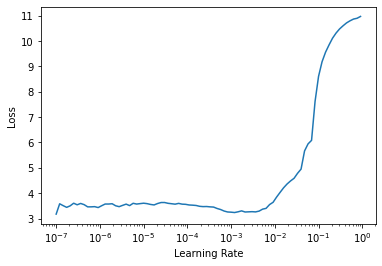

In [20]:
learn.lr_find(suggestions=True)

It's also not a bad idea to run a batch through your model and make sure the shape of what goes in, and comes out, looks right.

In [21]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape


(3,
 tensor(3.4790, device='cuda:0', grad_fn=<NllLossBackward>),
 torch.Size([2, 102, 50264]))

## Training the model

Finally, we train the model

In [22]:
#learn.fit_one_cycle(1, lr_max=3e-5)
learn.fit_one_cycle(1, lr_max=3e-5)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,time
0,1.832468,1.615264,0.422462,0.204627,0.295580,08:40


And now we can look at the "greedy decoded" predictions ...

In [ ]:
# learn.fine_tune(100)
#learn.fit(n_epoch=200, lr=1e-7, min_delta=0.1, patience=2)
#learn.fit(n_epoch=3, lr=1e-7, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=2))

Let us to show two generated summaries for two input texts of the training dataset:

In [ ]:
learn.show_results(learner=learn, max_n=2)

## How to use the model to generate summaries?


Even better though, blurr augments the fastai Learner with a `blurr_summarize` method that allows you to use huggingface's `PreTrainedModel.generate` method to create something more human-like.

In [ ]:
input_text = """
The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,050 even before the Air Asia plane vanished. Two incidents involving Malaysia Airlines planes - one over eastern Ukraine and the other in the Indian Ocean - led to the deaths of 537 people, while an Air Algerie crash in Mali killed 116 and TransAsia Airways crash in Taiwan killed a further 49 people. The remaining 456 fatalities were largely in incidents involving small commercial planes or private aircraft operating on behalf of companies, governments or organisations. Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949 - totalling just 111 across the whole world over the past 12 months. The all-time deadliest year for aviation was 1972 when a staggering 2,429 people were killed in a total of 55 plane crashes - including the crash of Aeroflot Flight 217, which killed 174 people in Russia, and Convair 990 Coronado, which claimed 155 lives in Spain. However this year's total death count of 1,212, including those presumed dead on board the missing Air Asia flight, marks a significant rise on the very low 265 fatalities in 2013 - which led to it being named the safest year in aviation since the end of the Second World War. Scroll down for videos. Deadly: The past 12 months have been the worst for aviation fatalities so far this decade - with the total of number of people killed if airline crashes reaching 1,158 even before the Air Asia plane (pictured) vanished. Fatal: Two incidents involving Malaysia Airlines planes - one over eastern Ukraine (pictured) and the other in the Indian Ocean - led to the deaths of 537 people. Surprising: Despite 2014 having the highest number of fatalities so far this decade, the total number of crashes was in fact the lowest since the first commercial jet airliner took off in 1949. 2014 has been a horrific year for Malaysia-based airlines, with 537 people dying on Malaysia Airlines planes, and a further 162 people missing and feared dead in this week's Air Asia incident. In total more than half the people killed in aviation incidents this year had been flying on board Malaysia-registered planes. In January a total of 12 people lost their lives in five separate incidents, while the same number of crashes in February killed 107. 
"""

outputs = learn.blurr_summarize(input_text, early_stopping=True, num_beams=4, num_return_sequences=3)

print('Examples of summaries generated by the model:')
for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

What about inference?  Easy!

## Exporting the model
We now save the model into a file pkl. We assume that its filename should be the same that the dataset name.

First of all, if you are running on google colab, you should mount your google drive:

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    root_colab='drive/My Drive/Colab Notebooks/'
    root=root_colab+'NLPwithDL/TextSummarization/'
else:
    print('Not running on CoLab')
    root='./'

In [ ]:
path_model=root+'models/'+name_dataset+'.pkl'
learn.export(fname=path_model)
print('model was saved into {}'.format(path_model))

After, you could load the model and use it to generate a summary

In [ ]:
#load the model
model = load_learner(fname=path_model)
print('{}  was loaded'.format(path_model))
#we use it to create a summary
model.blurr_summarize(input_text)